In [46]:
import h5py
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [16]:
input_folder = 'F:/2024_Lightning_Analysis/GPM_data/100_100_km_all_778_initial_CMB/'
file_path = input_folder + '2B-CS-43E40N44E40N.GPM.DPRGMI.CORRA2022.20180513-S225555-E225608.023900.V07A' +'.HDF5'

Get basic info on Dataset contents

In [5]:
def explore_hdf5_file(file_path):

    def print_structure(name, obj):
        """Callback to print the structure of the file."""
        if isinstance(obj, h5py.Group):
            print(f"Group: {name}")
        elif isinstance(obj, h5py.Dataset):
            print(f"Dataset: {name}, Shape: {obj.shape}, Dtype: {obj.dtype}")

    try:
        with h5py.File(file_path, 'r') as hdf_file:
            print(f"Exploring file: {file_path}\n")
            hdf_file.visititems(print_structure)
    except Exception as e:
        print(f"An error occurred: {e}")

Go deeper - get info structured

In [8]:
def list_hdf5_datasets(file_path):
    dataset_names = []

    def collect_datasets(name, obj):
        """Callback to collect dataset names."""
        if isinstance(obj, h5py.Dataset):
            dataset_names.append(name.split("/")[-1])  # Store only variable name (not full path)

    try:
        with h5py.File(file_path, 'r') as hdf_file:
            hdf_file.visititems(collect_datasets)
        return dataset_names
    except Exception as e:
        print(f"An error occurred: {e}")
        return []


Write names of all variables to a file

In [11]:
def save_dataset_names_to_file(file_path, output_file):
    """Extract dataset names and save them to a text file."""
    dataset_names = []

    def collect_datasets(name, obj):
        if isinstance(obj, h5py.Dataset):
            dataset_names.append(name.split("/")[-1])  # Store only variable names

    try:
        with h5py.File(file_path, 'r') as hdf_file:
            hdf_file.visititems(collect_datasets)
        
        # Save to file
        with open(output_file, "w") as f:
            for name in sorted(set(dataset_names)):  # Sort & remove duplicates
                f.write(name + "\n")
        
        print(f"Dataset names saved to {output_file}")
    
    except Exception as e:
        print(f"An error occurred: {e}")

In [31]:
explore_hdf5_file(file_path)

Exploring file: F:/2024_Lightning_Analysis/GPM_data/100_100_km_all_778_initial_CMB/2B-CS-43E40N44E40N.GPM.DPRGMI.CORRA2022.20180513-S225555-E225608.023900.V07A.HDF5

Dataset: AlgorithmRuntimeInfo, Shape: (1,), Dtype: |S68
Group: KuGMI
Group: KuGMI/FLG
Dataset: KuGMI/FLG/estimPrecipInClutter, Shape: (20, 49), Dtype: int16
Dataset: KuGMI/FLG/ioQuality, Shape: (20, 49), Dtype: int32
Dataset: KuGMI/FLG/multiScatCalc, Shape: (20, 49), Dtype: int32
Dataset: KuGMI/FLG/scanPatternFlag, Shape: (20,), Dtype: int16
Group: KuGMI/Input
Dataset: KuGMI/Input/ellipsoidBinOffset, Shape: (20, 49), Dtype: float32
Dataset: KuGMI/Input/localZenithAngle, Shape: (20, 49), Dtype: float32
Dataset: KuGMI/Input/lowestClutterFreeBin, Shape: (20, 49), Dtype: int16
Dataset: KuGMI/Input/piaEffective, Shape: (20, 49), Dtype: float32
Dataset: KuGMI/Input/piaEffectiveReliabFlag, Shape: (20, 49), Dtype: int16
Dataset: KuGMI/Input/piaEffectiveSigma, Shape: (20, 49), Dtype: float32
Dataset: KuGMI/Input/precipTypeQualityFl

In [ ]:
dataset_list = list_hdf5_datasets(file_path)
print(dataset_list)

In [13]:
output_file = "data_extracted/GPM_variabless.txt"
save_dataset_names_to_file(file_path, output_file)

Dataset names saved to GPM_vars.txt


Names of variables - in column

In [36]:
def save_full_dataset_paths(file_path, output_file):
    """Extract full dataset paths and save them to a text file, ensuring no duplicates."""
    dataset_paths = set()  # Use a set to avoid duplicates

    def collect_datasets(name, obj):
        if isinstance(obj, h5py.Dataset):
            dataset_paths.add(name)  # Store full dataset path in a set

    try:
        with h5py.File(file_path, 'r') as hdf_file:
            hdf_file.visititems(collect_datasets)

        # Ensure output directory exists
        os.makedirs(os.path.dirname(output_file), exist_ok=True)

        # Save full dataset paths to file (column format)
        with open(output_file, "w") as f:
            for path in sorted(dataset_paths):  # Sort for readability
                f.write(path + "\n")
        
        print(f"Full dataset paths saved to {output_file}")

    except Exception as e:
        print(f"An error occurred: {e}")


In [38]:
def save_dataset_to_csv(file_path, dataset_path, output_dir="data_extracted"):
    """Extracts a dataset and saves it as a CSV file."""
    with h5py.File(file_path, 'r') as hdf_file:
        if dataset_path in hdf_file:
            data = hdf_file[dataset_path][:]
            
            # Define filename by replacing "/" with "_"
            dataset_name = dataset_path.replace("/", "_") + "_all.csv"
            output_file = os.path.join(output_dir, dataset_name)

            # Ensure output directory exists
            os.makedirs(output_dir, exist_ok=True)

            # Convert data to DataFrame and save
            df = pd.DataFrame(data)
            df.to_csv(output_file, index=False, header=False)  # No index, no header

            print(f"Saved: {output_file}")
        else:
            print(f"Dataset {dataset_path} not found.")

In [37]:
output_file = "data_extracted/var_full_names.txt"
save_full_dataset_paths(file_path, output_file)

Full dataset paths saved to data_extracted/var_full_names.txt


Exploring data on one variable: (Wind Speed, ...)

In [34]:
def get_dataset(file_path, dataset_path):
    """Extracts a dataset as a NumPy array."""
    with h5py.File(file_path, 'r') as hdf_file:
        if dataset_path in hdf_file:
            data = hdf_file[dataset_path][:]
            return data
        else:
            print(f"Dataset {dataset_path} not found.")
            return None

Get data to file

In [42]:
# Usage Example
var_name = "KuGMI/tenMeterWindSpeed"  # Replace with the dataset you want to save
save_dataset_to_csv(file_path, var_name)

Saved: data_extracted\KuGMI_tenMeterWindSpeed_all.csv


Look at data

In [35]:
#var_name = "KuGMI/Input/..."  # Update this based on Step 1
var_name = "KuGMI/tenMeterWindSpeed"

wind_speed_data = get_dataset(file_path, var_name)

if wind_speed_data is not None:
    print(wind_speed_data.shape)  # Check shape
    print(wind_speed_data)        # Print data

(20, 49)
[[0.5985914  0.47689113 0.37347534 0.2978614  0.2614708  0.26982415
  0.3120416  0.371459   0.2927214  0.21552576 0.36652842 0.6191702
  0.9464657  1.2900535  1.645281   2.0096366  2.3840132  2.7377934
  2.7953672  2.8357444  2.8607314  2.872519   2.8739877  2.8683815
  2.8596933  2.8525643  2.8526518  2.8309872  2.7065248  2.5820084
  2.4619315  2.352234   2.2459412  2.1599402  2.0960932  2.0528414
  2.026136   1.9902638  1.9148089  1.828246   1.7240081  1.5990038
  1.4567627  1.3085997  1.175498   1.1054688  1.1568615  1.2225862
  1.2305298 ]
 [0.6260987  0.49037966 0.36816025 0.26711378 0.2018343  0.19437881
  0.23979984 0.27458513 0.17472032 0.2851929  0.5075473  0.7674662
  1.0532256  1.376835   1.7280854  2.0878692  2.4573383  2.6345704
  2.7019322  2.7515085  2.784973   2.8043416  2.812421   2.81219
  2.8074458  2.8026047  2.8030324  2.7052295  2.5860493  2.467391
  2.3536503  2.2507048  2.1673148  2.1078155  2.0616844  2.0374286
  2.0305922  1.9706736  1.9070727  1.832

Plot the data!

In [43]:
def plot_dataset(file_path, var_name):
    """Extracts and plots dataset as a time-value graph."""
    with h5py.File(file_path, 'r') as hdf_file:
        if var_name in hdf_file:
            data = hdf_file[var_name][:]
            
            # Flatten data if multi-dimensional (using first row)
            if data.ndim > 1:
                data = data[0, :]  # Take first row
            
            # Generate x-axis as simple indices (assuming time steps)
            time = np.arange(len(data))

            # Plot the data
            plt.figure(figsize=(10, 5))
            plt.plot(time, data, marker='o', linestyle='-', color='b', markersize=3)
            plt.xlabel("Time Step")
            plt.ylabel(var_name)
            plt.title(f"Time Series Plot for {var_name}")
            plt.grid(True)
            plt.show()

        else:
            print(f"Dataset {var_name} not found.")


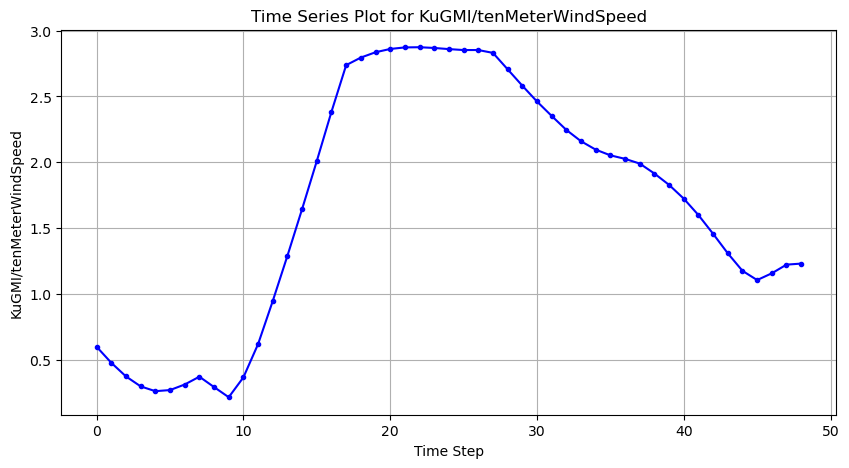

In [47]:
var_name = "KuGMI/tenMeterWindSpeed"  # Replace with the dataset you want to save
plot_dataset(file_path, var_name)